In [2]:
import numpy as np
import pandas as pd
import os, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import fft
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(torch.__version__)

Using device: cuda
2.6.0+cu118


In [4]:
df = pd.read_csv('../regularset.csv') # reads in codes csv as a mutable df :-) contains message, ecl, code, dft cols


In [5]:
df = df.drop([0])
df['dft'] = df['dft ']

In [6]:
# parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [7]:
# grabs a centered subarray of a given array with dimensions (2L+1) by (2L+1)
def get_centered_subarray(array, L):
    # old way -- 
    # L = (L * 2) + 1
    # start = center - (L // 2)
    # end = center + (L + 1) // 2
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [8]:
df.describe

<bound method NDFrame.describe of                 message   ecl  \
1      p6EG4QY8KkhYnIqX   low   
2      F9nH5ms4nKaowmGT   low   
3      Wbfi9me34iIYUPa4   low   
4      xFX738D9PFRFKrWY   low   
5      NtIx1n7gwlUpBPdC   low   
...                 ...   ...   
59995  YJdWpCnjwlu1QbSN  high   
59996  Q6uRfuOEDbFtkHJM  high   
59997  uObBgAn5KAzhoBjg  high   
59998  h3W7XErFozVHsUnH  high   
59999  zQF5zP5gvhruSFKs  high   

                                                    code  \
1      1111111001100000001100111111110000010000011111...   
2      1111111000110000011100111111110000010001101001...   
3      1111111000011101111010111111110000010001001110...   
4      1111111001011010011100111111110000010010100101...   
5      1111111001001101111100111111110000010101100110...   
...                                                  ...   
59995  1111111000000001011100111111110000010010100001...   
59996  1111111001100100011100111111110000010101010110...   
59997  1111111001010100001100

In [9]:
def slopeSum(matrix,start,slope):
        n = matrix.shape[0]
        row, column = start[0],start[1]
        rise, run = slope[0],slope[1]
        rowSum = 0
        rowSum += matrix[row][column]
        for i in range(n-1):
            newRow = abs(row+rise) % n
            newColumn = abs(column+run) % n
            rowSum += matrix[newRow][newColumn]
            row = row+rise
            column = column+run
        return rowSum

In [10]:
def rowSums(matrix):
        n = matrix.shape[0]
        sums = []
        for i in range(n):
            start = (i,0)
            slope = (0,1)
            sums.append(slopeSum(matrix, start, slope))
        return sums

df['rowSums'] = df['code_array'].apply(rowSums)

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        input_size = (4*L)+2
        output_size = 29 
        self.fc1 = nn.Linear(input_size, output_size)
    def forward(self, x):
        return self.fc1(x)  # No activation for regression

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

import torch.nn.functional as F

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained PyTorch regression model on the test set.

    Parameters:
    - model: The trained PyTorch model.
    - X_test: The input features for the test set (shape: (num_samples, input_size)).
    - y_test: The true labels for the test set (shape: (num_samples, 29)).

    Returns:
    - mse: The mean squared error of the model on the test set.
    """
    
    model.eval()

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)

    # Calculate Mean Squared Error
    # mse = F.mse_loss(predictions, y_test_tensor).item()
    #Calculate L1 norm
    mae = F.l1_loss(predictions, y_test_tensor).item()
    zero_one_loss = (predictions != y_test_tensor).float().mean().item()
    
    
    print(f"Test Mean Squared Error: {mse:.4f}")
    return mae, zero_one_loss


# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main Loop Over L Values
stat = []
for L in range(10, 0, -1):
    # Convert features to numpy arrays
    def extract_features(row):
        real_features = get_dft_column(row['dft_real_rolled'])
        imag_features = get_dft_column(row['dft_imag_rolled'])
        return np.concatenate((real_features, imag_features))

    X = np.stack(df.apply(extract_features, axis=1).values)

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = np.stack(df['rowSums'].values)  # Assuming `df['target']` contains labels

    print(X[0])
    print(y[0])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize Model, Optimizer, and Loss Function
    model = Model(L).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()  # Assuming a regression task

    # Train Model
    train_model(model, train_loader, criterion, optimizer, epochs=25)

    # Evaluate Model
    mae, zol = evaluate_model(model, X_test, y_test)
    stat.append((L, mae, zol))

    print(stat)


NameError: name 'get_dft_column' is not defined

In [13]:
#fixed L

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define Model Class
# Define Model Class
# Define Model Class
class Model(nn.Module):
    def __init__(self, L):
        super(Model, self).__init__()
        input_size = 29
        hidden_size = 2*L+1
        output_size = 29
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        return self.fc2(self.fc1(x))  # No activation for regression


# Training Loop (Records Accuracy Every 5 Epochs)
def train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=25):
    model.train()
    stat = []  # Store accuracy every 5 epochs
    
    for epoch in range(1, epochs + 1):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate every 5 epochs
        if epoch % 5 == 0:
            mse, mae, zol = evaluate_model(model, X_test, y_test)
            stat.append((epoch, mse, mae, zol))
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Test Zol: {zol:.4f}")

    return stat

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained PyTorch regression model on the test set.

    Parameters:
    - model: The trained PyTorch model.
    - X_test: The input features for the test set (shape: (num_samples, input_size)).
    - y_test: The true labels for the test set (shape: (num_samples, 29)).

    Returns:
    - mse: The mean squared error of the model on the test set.
    """
    
    model.eval()

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)

    # Calculate Mean Squared Error
    mse = F.mse_loss(predictions, y_test_tensor).item()
    #Calculate L1 norm
    mae = F.l1_loss(predictions, y_test_tensor).item()
    zero_one_loss = (predictions.round() != y_test_tensor).float().mean().item()
    
    
    print(f"Test Mean Squared Error: {mse:.4f}")
    return mse, mae, zero_one_loss

# Device Setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Fixed L at 5**
L = 5


y = np.stack(df['rowSums'].values)  # Assuming `df['target']` contains labels
X = y

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize Model, Optimizer, and Loss Function
model = Model(L).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Assuming a regression task

# Train and Collect Accuracy Every 5 Epochs
stat = train_model(model, train_loader, criterion, optimizer, X_test, y_test, epochs=50)

print("Final Accuracy Stats:", stat)


Test Mean Squared Error: 2.2837
Epoch 5/50, Loss: 2.3464, Test Zol: 0.7304
Test Mean Squared Error: 2.1401
Epoch 10/50, Loss: 1.9495, Test Zol: 0.7162
Test Mean Squared Error: 2.0769
Epoch 15/50, Loss: 2.0809, Test Zol: 0.7038
Test Mean Squared Error: 2.0407
Epoch 20/50, Loss: 1.9493, Test Zol: 0.6884
Test Mean Squared Error: 2.0201
Epoch 25/50, Loss: 1.8807, Test Zol: 0.6739
Test Mean Squared Error: 2.0051
Epoch 30/50, Loss: 2.1760, Test Zol: 0.6618
Test Mean Squared Error: 2.0038
Epoch 35/50, Loss: 2.1177, Test Zol: 0.6563
Test Mean Squared Error: 1.9946
Epoch 40/50, Loss: 2.0862, Test Zol: 0.6547
Test Mean Squared Error: 1.9903
Epoch 45/50, Loss: 2.1182, Test Zol: 0.6546
Test Mean Squared Error: 1.9844
Epoch 50/50, Loss: 2.0225, Test Zol: 0.6556
Final Accuracy Stats: [(5, 2.2836899757385254, 1.1949262619018555, 0.7304454445838928), (10, 2.1400773525238037, 1.1504539251327515, 0.7161666750907898), (15, 2.076850175857544, 1.1232019662857056, 0.7038247585296631), (20, 2.040659427642822

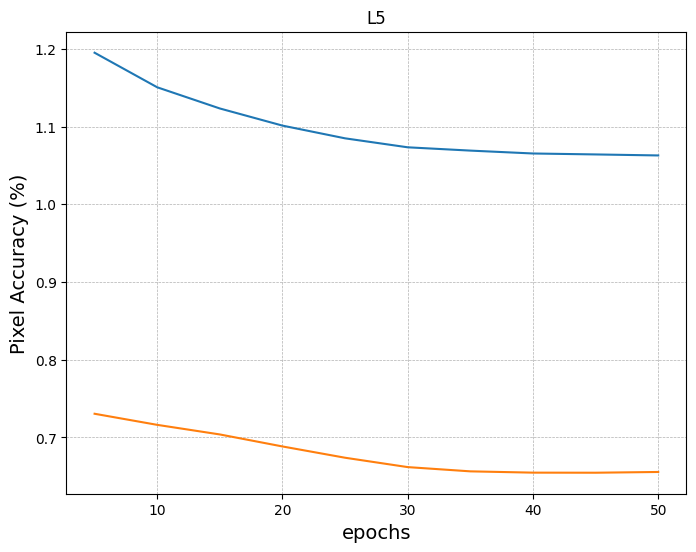

In [14]:
#l graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('epochs', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('L5')
ax.plot([st[0] for st in stat], [st[2] for st in stat]) # plots accuracy vs L -- we can add labels later!
ax.plot([st[0] for st in stat], [st[3] for st in stat])

In [36]:
fig.savefig('Row_Sum_Predictions_25epoch.png', dpi=300)

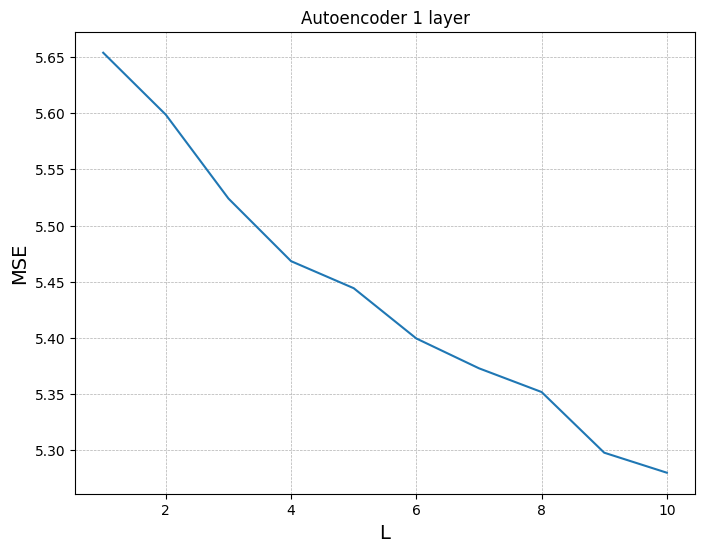

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_title('Autoencoder 1 layer')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [13]:
stat = [(10, 0.7218579072532699), (9, 0.7176319857312723), (8, 0.7140148632580262), (7, 0.7099592746730083), (6, 0.7058540428061831), (5, 0.7026167261196987), (4, 0.6979101268331351), (3, 0.6944241973840666), (2, 0.6906887633769322), (1, 0.5771642885453825)]